In [40]:
import math
import json
import re
import copy

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

#sns.set(style="darkgrid")
sns.set(style="whitegrid", rc={'figure.figsize':(12,6)}, font_scale=1.3)

# Load an example dataset with long-form data
#fmri = sns.load_dataset("fmri")

# Plot the responses for different events and regions
#plt = sns.lineplot(x="timepoint", y="signal",
#             hue="region", style="event",
#             data=fmri)


#plt.show()

In [41]:

#with open('../1_pop_cleaning/communes_VD_clean.json', 'r') as cf:
#    communes = json.load(cf)
#    for c in communes:
#        for hy in c["hab_year"]:
#            hy["pop"] = int(hy["pop"])
#            hy["year"] = int(hy["year"])
#cdata = pd.DataFrame(communes)
#cdata

In [42]:
def interpolator(data_points):
    """Returns a linear interpolator from the given dataPoints
    @param {*} dataPoints an array of length 2 arrays, each sub-array is a coordinate with sub-array[0]=x, sub-array[1]=y
    @returns interpolate(x) a function taking a value x and returning the linear interpolation of y at x, or null if x is outside the x range of dataPoints
    """
    data_points = sorted(data_points, key=lambda hy:hy[0])
    lendp = len(data_points)
    if lendp<=1:
            return lambda x: None
    else:
        def interpolate(x):
            
            for dp in data_points:
                if dp[0] == x: return dp[1]
            #if data_points[0][0]==x:
            #    return data_points[0][1]
            #if data_points[lendp-1][0]==x:
            #    return data_points[lendp][1]
            for i in range(0,lendp-1):
                if data_points[i+1][0]>x and data_points[i][0]<=x:
                    a = data_points[i]
                    b = data_points[i+1]
                    return a[1]+ (b[1]-a[1])/(b[0]-a[0]) * (x-a[0])
            return None
        return interpolate
    

In [43]:
def exponential_interpolator(data_points):
    linear_interpolator = interpolator([(dp[0],math.log(dp[1])) for dp in data_points])
    def exp_interpolate(x):
        log_result = linear_interpolator(x)
        if log_result:
            return math.exp(log_result)
    return exp_interpolate

In [44]:
a = [(0.01,0.1),(1,1),(2,3),(3,6)]
print(f"a = {a}")
x=2.5
interp = interpolator(a)
print(f"interp({x}) = {interp(x)}")
expterp = exponential_interpolator(a)
print(f"expterp({x}) = {expterp(x)}")

a = [(0.01, 0.1), (1, 1), (2, 3), (3, 6)]
interp(2.5) = 4.5
expterp(2.5) = 4.242640687119285


In [45]:
class HabYear:
    UNIT_EINW_1 = ['Beisassen',
    'Bürger',
    'Einw',
    'Einw Feuerschaukreis',
    'Einw Kirchgem.',
    'Einw. Kirchgem', 'Einwohner',
    'Kirchgenossen', 'Kommunikanten'
    ]
    UNIT_HAUSHALTE_5 = [
    'Erwachsene', 'Erwachsenen', 'Fam', 'Feuerstellen', 'Feuerstätten',
    'Feuerstätten (mit Sermuz, heute Gem', 'Haushalt', 'Haushalte',
    'Haushalte Kirchgem', 'Haushaltungen', 'Hausväter', 'Herdstellen',
    'Herdstätten', 'Hofgenossen', 'Hofstätten', 'Häuser', 'Höfe',
    'Steuerpflichtige',
    ]
    ACCEPTED_UNITS = UNIT_EINW_1+UNIT_HAUSHALTE_5
    
    def __init__(self, year, pop, unit=None, type_="original",ygr=None):
        self.year = int(year) 
        self.pop = float(pop)
        self.unit = unit.strip() if unit else "undefined"
        self.type = type_
        self.ygr = ygr
    def to_dict(self):
        hyjson = copy.copy(self.__dict__)
        if "next" in hyjson and hyjson["next"]:
            hyjson["next"] = hyjson["next"].year
        if "previous" in hyjson and hyjson["previous"]:
            hyjson["previous"] = hyjson["previous"].year
        hyjson = {k:v for k,v in hyjson.items() if v}
        return hyjson
    def to_json(self):
        return json.dumps(self.to_dict())
    def __str__(self):
        type_evidence = "-ORIGINAL" if self.type=="original" else ""
        return "HabYear"+type_evidence+"("+self.to_json().__str__()+")"
    def __repr__(self):
        return self.__str__()
    def __copy__(self):
        tr = HabYear(self.year,self.pop,self.unit,self.type,self.ygr)
        for k,v in self.__dict__.items():
            tr.__dict__[k] = v
        return tr
    def copy(self): return self.__copy__()
    def __deepcopy__(self,memo=None):
        tr = self.__copy__()
        tr.next = None
        tr.previous = None
        return tr
    def deepcopy(self): return self.__deepcopy__()
    def convert_unit_to_Einw(self, conversion_factor):
        if self.unit in HabYear.UNIT_HAUSHALTE_5:
            self.original_unit = self.unit
            self.einw_conversion_factor = conversion_factor
            self.pop = int(np.round(conversion_factor*self.pop))
        self.unit = "Einw"
    def compute_growth_rate(self):
        # g^dy p1 = p2 -> g = (p2/p1)^(1/dy) -> log(g) = (log(p2)-log(p1))/dy
        if self.next:
            dy = self.next.year - self.year
            self.ygr = (self.next.pop / self.pop) ** (1/dy)
        else:
            self.ygr = None
    @staticmethod
    def interpolator(hys, interpolator_func = exponential_interpolator, type_ = "interpolated"):
        hys = sorted(hys, key=lambda hy:hy.year)
        lenhys = len(hys)
        if lenhys<=1:
                return lambda x: None
        else:
            pop_interpolator = interpolator_func([(hy.year,hy.pop) for hy in hys])
            def hy_interpolate(year):
                for hy in hys:
                    if hy.year == year: return hy
                pop = pop_interpolator(year)
                for i in range(0,lenhys-1):
                    if hys[i+1].year>year and hys[i].year<=year:
                        pred = hys[i]
                        return HabYear(year, pop, pred.unit, type_, pred.ygr)
                return None
            return hy_interpolate

In [46]:
class HabYearTimeSeries:
    def __init__(self, json_hab_year):
        self.hab_year = [HabYear(hy["year"], hy["pop"], hy.get("unit"), "original") for hy in json_hab_year]
        self.raw_hab_year = copy.deepcopy(json_hab_year)
    def to_dict(self, only_original = True):
        hytsjson = copy.copy(self.__dict__)
        if "interpolate" in hytsjson:
            del hytsjson["interpolate"]
        if only_original:
            hytsjson["hab_year"] = [hy for hy in hytsjson["hab_year"] if hy.type=="original"]
        hytsjson["hab_year"] = [hy.to_dict() for hy in hytsjson["hab_year"]]
        return hytsjson
    def to_json(self):
        return json.dumps(self.to_dict())
    def __str__(self):
        return "HabYearTimeSeries("+self.to_json().__str__()+")"
    def __repr__(self):
        return self.__str__()
    def has_pop_data(self, year, type_=None):
        for hy in self.hab_year:
            if hy.year==year:
                if not type_:
                    return True
                elif hy.type==type:
                    return True
        return False
    def get_hab_year(self,year):
        for hy in self.hab_year:
            if hy.year==year:
                return hy
    def order_hab_year(self):
        if len(self.hab_year)>1:
            self.hab_year = sorted(self.hab_year,key=lambda hy: hy.year)
            for i in range(1,len(self.hab_year)):
                self.hab_year[i].previous = self.hab_year[i-1]
                self.hab_year[i-1].next = self.hab_year[i]
            # for original hy: next&previous are only original ones ;-)
            original_hab_years = [hy for hy in self.hab_year if hy.type=="original"]
            for i in range(1,len(original_hab_years)):
                original_hab_years[i].previous = original_hab_years[i-1]
                original_hab_years[i-1].next = original_hab_years[i]
        if len(self.hab_year)>0:
            self.hab_year[0].previous = None
            self.hab_year[len(self.hab_year)-1].next = None
    def detect_duplicated_years(self):
        year_dict = {}
        for hy in self.hab_year:
            if hy.year in year_dict:
                year_dict[hy.year].append(hy)
            else:
                year_dict[hy.year] = [hy]
        duplicates = {y:sorted(hys,key=lambda hy: - hy.pop) for y,hys in year_dict.items() if len(hys)>1}
        return duplicates
    def remove_duplicates(self):
        duplicates = self.detect_duplicated_years()
        self.hab_year = [hy for hy in self.hab_year if hy.year not in duplicates or (hy.unit=="Einw" and self.name not in ["Därstetten", "Egerkingen"])]
    def remove_non_accepted_units(self):
                self.hab_year = [hy for hy in self.hab_year if hy.unit in HabYear.ACCEPTED_UNITS]
    def convert_hab_year_to_Einw(self, conversion_factor):
        for hy in c.hab_year:
            hy.convert_unit_to_Einw(conversion_factor)
    def compute_growth_rates(self):
        for hy in self.hab_year:
            hy.compute_growth_rate()
    def create_hab_years_interpolator(self):
        self.order_hab_year()
        self.interpolate = HabYear.interpolator([hy for hy in self.hab_year])
    def interpolate_hab_years(self, years):
        for y in years:
            hy = self.interpolate(y)
            if hy and not self.has_pop_data(y) :
                self.hab_year.append(hy)
        self.order_hab_year()

In [47]:

            
        
class Commune(HabYearTimeSeries):
    COMMUNES_NAME_REGEX = re.compile(r"\W\(?Gemeinde\)?")
    def __init__(self, json_commune):
        super(Commune, self).__init__(json_commune["hab_year"])
        self.name = self.COMMUNES_NAME_REGEX.sub("",json_commune["name"])
        self.canton = json_commune["canton"]
        self.url = json_commune["url"]
        self.firstmention = json_commune["firstmention"] if "firstmention" in json_commune else None
        self.notes = json_commune["notes"] if "notes" in json_commune else ""
    def __str__(self):
        return "Commune("+self.to_json().__str__()+")"
    def __repr__(self):
        return self.__str__()       

# Loading data & assembling reviewedCommunes with non-reviewed communes

In [48]:

#with open('../1_pop_cleaning/communes_V2_checkpoint_1555579436131.json', 'r') as cf:
with open('../1_pop_cleaning/communes_V2_checkpoint_1558469560478.json', 'r') as cf:
    data = json.load(cf)
    

In [49]:

reviewedCommunes = data["reviewedCommunes"]
communesToReview = data["communesToReview"]

# remember that some are reviewed and some not
for commune in reviewedCommunes:
    commune["hand_reviewed"] = True
for commune in communesToReview:
    commune["hand_reviewed"] = False
    
print("communes[0].keys()")
print(reviewedCommunes[0].keys())
print("communesToReview[0].keys()")
print(communesToReview[0].keys())

communes[0].keys()
dict_keys(['url', 'text', 'hab_year', 'problem_time', 'problem_unit', 'problem_start', 'name', 'gravity', 'actionsDone', 'actionsUndone', 'canton', 'firstmention', 'problems', 'warnings', 'hand_reviewed'])
communesToReview[0].keys()
dict_keys(['url', 'text', 'hab_year', 'problem_time', 'problem_unit', 'problem_start', 'name', 'gravity', 'actionsDone', 'actionsUndone', 'canton', 'firstmention', 'notes', 'problems', 'warnings', 'hand_reviewed'])


In [50]:
# class version

columns_communes = ["name","canton","url","firstmention","hab_year","raw_hab_year","notes"]

communes = reviewedCommunes+communesToReview
communes = [Commune(json_commune)
    for json_commune in communes
]

# Drop thurgau for now
print(len(communes))
TGcommunes = [c for c in communes if c.canton=="TG"]
communes = [c for c in communes if c.canton!="TG"]
print(len(communes))

#dfcommunes = pd.DataFrame(communes)[columns_communes]

#pd.set_option('display.max_rows', None) 
#dfcommunes

2242
2162


In [51]:
for c in communes:
    if c.name == "Därstetten":
        print("WHY DÄRSTETTEN?!?!! WHYY!!?")

WHY DÄRSTETTEN?!?!! WHYY!!?


In [52]:
da = [(5,6),(7,8),(9,10)]
da

[(5, 6), (7, 8), (9, 10)]

In [53]:
for i,(a,b) in enumerate(da):
    print(f"{i}: {a}, {b}")

0: 5, 6
1: 7, 8
2: 9, 10


# Available data across time

min(years) =  1177
Number of observations per year:
(1149.999, 1200.0]       3
(1200.0, 1250.0]         4
(1250.0, 1300.0]         9
(1300.0, 1350.0]        19
(1350.0, 1400.0]        28
(1400.0, 1450.0]       108
(1450.0, 1500.0]       205
(1500.0, 1550.0]        82
(1550.0, 1600.0]       118
(1600.0, 1650.0]       211
(1650.0, 1700.0]       269
(1700.0, 1750.0]       255
(1750.0, 1800.0]      1329
(1800.0, 1850.0]      2631
(1850.0, 1900.0]         0
dtype: int64


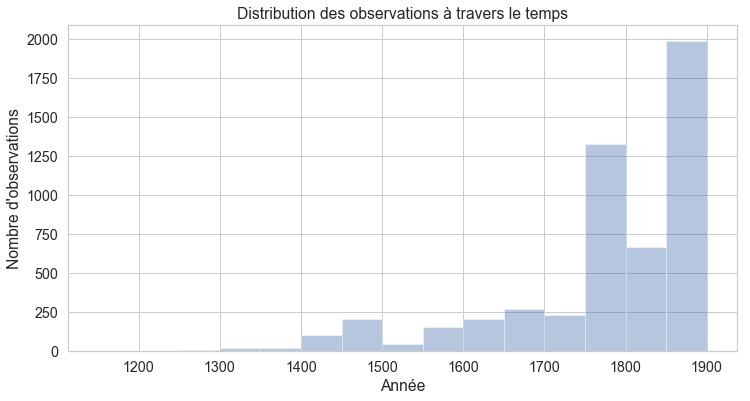

In [54]:
years_bins = range(1150,1901,50)

years = [hy.year for c in communes for hy in c.hab_year if hy.year<=1850]
print("min(years) = ", min(years))

print("Number of observations per year:")
print(pd.Series(years).value_counts(bins=years_bins,sort=False))

obs_distrib = sns.distplot(years, bins=years_bins, kde=False, rug=False)
obs_distrib.set_title('Distribution des observations à travers le temps')
obs_distrib.set(xlabel='Année', ylabel="Nombre d'observations")
obs_distrib.get_figure().savefig("obs_distrib.png") 


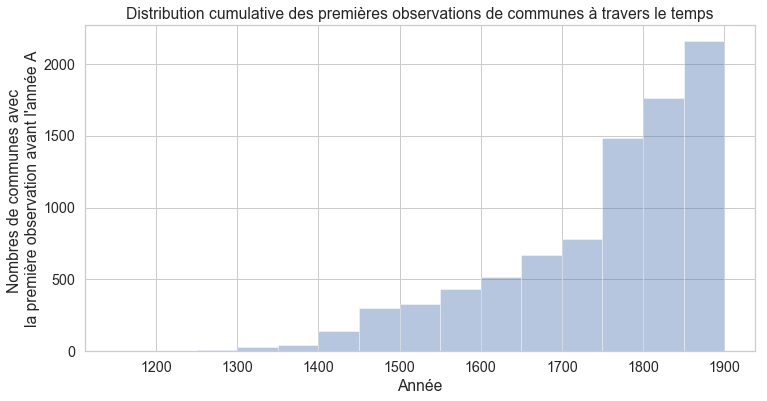

In [55]:


first_years = [min([y for hy in c.hab_year for y in [hy.year] if y<=1850]+[1850]) for c in communes ]

first_obs = sns.distplot(first_years, bins=years_bins, hist_kws=dict(cumulative=True),kde=False,rug=False)
#first_obs.set_title("Cumulative distribution of communes' first observation across time")
first_obs.set_title("Distribution cumulative des premières observations de communes à travers le temps")
#first_obs.set(xlabel='year', ylabel='# communes with first \nobservation before year Y')
first_obs.set(xlabel='Année', ylabel="Nombres de communes avec \nla première observation avant l'année A")
first_obs.get_figure().savefig("first_obs.png") 

In [81]:
len([y for y in first_years if y<1600])


434

# Unit transformation

In [56]:
units = [hy.unit  for c in communes for hy in c.hab_year if hy.year<1850]

print("Number of each type of units:")
print(pd.Series(units).value_counts())

Number of each type of units:
Einw                                               2814
Feuerstätten                                        157
Haushalte                                           146
Feuerstellen                                         28
Häuser                                               25
Haushaltungen                                        23
Einw Kirchgem.                                       13
Steuerpflichtige                                     11
Erwachsene                                            6
Kanoniker                                             6
Einw Feuerschaukreis                                  6
Einw. Kirchgem                                        6
Hofstätten                                            4
undefined                                             4
Herdstätten                                           3
Kommunikanten                                         3
Haushalt                                              3
Herdstellen       

In [57]:
pd.Series(units).unique()

array(['Haushalte', 'Einw', 'Feuerstätten', 'Haushaltungen', 'Häuser',
       'Kirchgenossen', 'Steuerpflichtige', 'Erwachsenen',
       'Einw Feuerschaukreis', 'Erwachsene', 'Kanoniker', 'Höfe',
       'Herdstellen', 'Hofstätten', 'Pesttote', 'Fam', 'Kommunikanten',
       'Feuerstellen', 'Einw Kirchgem.', 'Juden', 'Einw outlier',
       'Feuerstätten (mit Sermuz, heute Gem', 'Bürger',
       '(Pfarrei einschliesslich Molondin und Vuissens)', 'Haushalt',
       'Einwohner', 'undefined', 'Hofgenossen', 'Hausväter',
       'Einw Pedrinate', 'Herdstätten', 'Beisassen', 'Einw. Kirchgem',
       'Haushalte Kirchgem'], dtype=object)

### Finding the conversion factor

In [58]:

def one1one5(a,b):
    return (a.unit in HabYear.UNIT_EINW_1 and b.unit in HabYear.UNIT_HAUSHALTE_5) or (a.unit in HabYear.UNIT_HAUSHALTE_5 and b.unit in HabYear.UNIT_EINW_1)


# find duplicates
duplicates = [(c.name,c.canton,y,hys) for c in communes for y,hys in c.detect_duplicated_years().items() if one1one5(hys[0],hys[1])]

dfduplicates = pd.DataFrame([{
    "commune": cname,
    "canton": canton,
    "year": y,
    "pop_einw": hys[0].pop,
    "pop_haus": hys[1].pop,
    "ratio": hys[0].pop / hys[1].pop,
    "unit_haus": hys[1].unit} for cname, canton, y, hys in duplicates])
dfduplicates = dfduplicates.sort_values(["year","unit_haus","commune"])
print("Number of double Haushaltungen-Einw data")
print(len(duplicates))
dfduplicates

Number of double Haushaltungen-Einw data
25


,canton,commune,pop_einw,pop_haus,ratio,unit_haus,year
23,BE,Bern,500.0,100.0,5.000000,Feuerstätten,1200
15,GE,Hermance,400.0,80.0,5.000000,Haushaltungen,1444
22,ZH,Regensdorf,97.0,23.0,4.217391,Haushaltungen,1468
18,SH,Neunkirch,460.0,92.0,5.000000,Häuser,1530
1,VD,Lutry,902.0,191.0,4.722513,Haushalte,1550
13,NE,Fresens,181.0,38.0,4.763158,Häuser,1632
20,NE,"Verrières, Les",570.0,114.0,5.000000,Haushalte,1664
12,LU,Altbüron,390.0,65.0,6.000000,Steuerpflichtige,1695
14,LU,Altishofen,430.0,72.0,5.972222,Steuerpflichtige,1695
24,AG,Windisch,402.0,77.0,5.220779,Haushaltungen,1736


In [59]:
def boxplot_condition(df, groupings, ax=plt):
    groupings = [(unit, f, f(dfduplicates)) for unit, f in groupings]
    ax.boxplot(
        [df.ratio.loc[condition] for unit, f, condition  in groupings],
        labels = [unit+f" ({np.sum(condition)}, mean: {np.round(np.mean(df.ratio.loc[condition]),2)})" for unit, f, condition in groupings]
        )
    #ax.xticks(rotation=10)
    ax.tick_params(labelrotation=10)

    

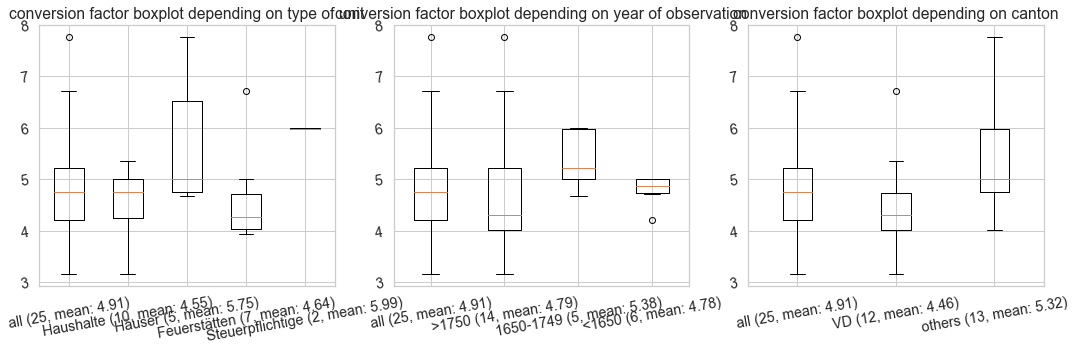

In [60]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,4.8))

haus_units = [
    ("all", lambda df: df.pop_haus>0),
    ("Haushalte", lambda df: (df.unit_haus =="Haushaltungen") | (df.unit_haus=="Haushalte")),
    ("Häuser", lambda df: df.unit_haus=="Häuser"),
    ("Feuerstätten", lambda df: df.unit_haus=="Feuerstätten"),
    ("Steuerpflichtige", lambda df: df.unit_haus=="Steuerpflichtige")
]

haus_years= [
    ("all", lambda df: df.year>=0),
    (">1750", lambda df: df.year>1750),
    ("1650-1749", lambda df: (df.year>1650) & (df.year<=1750)),
    ("<1650", lambda df:  df.year<=1650),
]

haus_cantons = [
    ("all", lambda df: df.pop_haus>0),
    ("VD", lambda df: df.canton =="VD"),
    ("others", lambda df: df.canton !="VD"),
]

boxplot_condition(dfduplicates, haus_units, ax1)
ax1.set_title("conversion factor boxplot depending on type of unit")
boxplot_condition(dfduplicates, haus_years, ax2)
ax2.set_title("conversion factor boxplot depending on year of observation")
boxplot_condition(dfduplicates, haus_cantons, ax3)
ax3.set_title("conversion factor boxplot depending on canton")
None

In [61]:
conversion_factor = np.mean(dfduplicates.ratio)
print(f"conversion factor: {np.round(conversion_factor,3)}")

conversion factor: 4.906


### Doing the conversion

Remove non-Einw data in duplicated years, as well as non-accepted units

In [62]:
for c in communes:
    c.remove_duplicates()
    c.remove_non_accepted_units()
    c.convert_hab_year_to_Einw(conversion_factor)

In [63]:
c = communes[9]
duplicates = c.detect_duplicated_years()
c.hab_year

[HabYear-ORIGINAL({"year": 1409, "pop": 118, "unit": "Einw", "type": "original", "original_unit": "Feuerst\u00e4tten", "einw_conversion_factor": 4.906486226243853}),
 HabYear-ORIGINAL({"year": 1550, "pop": 167, "unit": "Einw", "type": "original", "original_unit": "Feuerst\u00e4tten", "einw_conversion_factor": 4.906486226243853}),
 HabYear-ORIGINAL({"year": 1764, "pop": 251.0, "unit": "Einw", "type": "original"}),
 HabYear-ORIGINAL({"year": 1850, "pop": 390.0, "unit": "Einw", "type": "original"}),
 HabYear-ORIGINAL({"year": 1900, "pop": 354.0, "unit": "Einw", "type": "original"}),
 HabYear-ORIGINAL({"year": 1950, "pop": 325.0, "unit": "Einw", "type": "original"}),
 HabYear-ORIGINAL({"year": 2000, "pop": 345.0, "unit": "Einw", "type": "original"})]

In [64]:
units = [hy.unit  for c in communes for hy in c.hab_year if hy.year<1850]

print("Number of each type of units:")
print(pd.Series(units).value_counts())

Number of each type of units:
Einw    3230
dtype: int64


### Computing growth rates

In [65]:
for c in communes:
    c.order_hab_year()
    c.compute_growth_rates()
    

# Doing the interpolation

Create an interpolator per commune:

In [66]:
for c in communes:
    c.create_hab_years_interpolator()
    

## How to extrapolate for communes without data?

### options:
- compute year-by-year growth rates for communes with data
   -> use the average per-year growth rate to find a growth-rates time series back in time
   -> use this growth-rate time series to go back in time
- use timespans of size X: compute average growth rate in each timespan
    -> go back in time with those growth rates
    
### proposition:
- each hy has a "type" entry with possible values: "original", "interpolated", "extrapolated"
- define function compute_growth_rate(c,y1,y2):
    return None if no data surrounding y1, y2
    return growth rate if it exists
- iterate over communes and timespans
    compute_growth_rate(...)
    -> growth rate of timespan = avg of computed growth rate
    
## TODO:
- compute_growth((x1,y1),(x2,y2))
- compute_growth(c,y1,y2)

In [67]:
all_years = np.unique(sorted(years))

compute all the intermediate year:

In [68]:
for c in communes:
    c.interpolate_hab_years(all_years)

### Computing the average growth rate in each year

In [69]:

def compute_avg_growth_rates(communes,years, refy=1850, max_pop_at_refy = 10000):
    """Assumes that each communes has the required data for each year (pop+growth rates)
    Note: the pop element (element 1 of each tuple) represents the population of communes with data at this moment
    """
    result = [(y,0,0) for y in years] # year: (total pop, total growth rate)
    for c in communes:
        refhy = c.interpolate(refy)
        if refhy and refhy.pop<max_pop_at_refy:
            for i,(y,pop,gr) in enumerate(result):
                hy = c.get_hab_year(y)
                if hy:
                    result[i] = (y, pop+hy.pop, gr+(hy.pop*hy.ygr))
    for i,(y,pop,gr) in enumerate(result):
        dy = 0
        if i<(len(result)-1):
            dy = result[i+1][0] - y
        ygr = gr/pop
        result[i] = (y,pop,ygr, ygr**dy, dy)
    return result

In [70]:
avg_ygr = compute_avg_growth_rates(communes,all_years)
avg_ygr


[(1177, 74, 1.001176014752242, 1.0274011384480906, 23),
 (1200, 76.02768424515854, 1.001176014752242, 1.0106340580176159, 9),
 (1209, 76.8361670503665, 1.001176014752242, 1.0118225785789627, 10),
 (1219, 77.74456867302563, 1.001176014752242, 1.0371069287138923, 31),
 (1250, 1480.6294308406677, 1.001365963545491, 1.0248749102757506, 18),
 (1268, 2218.8429260814023, 1.0037057210912919, 1.0111584112686236, 3),
 (1271, 2248.7033629706143, 1.0037591499681553, 1.0189375941381325, 5),
 (1276, 2590.6363832630223, 1.0033549260090906, 1.0067211075467077, 2),
 (1278, 3996.088186336955, 1.0033282740659886, 1.0758385969547706, 22),
 (1300, 8452.679966933501, 1.0036478423193345, 1.0073089913922557, 2),
 (1302, 8872.543666354371, 1.0035050745395413, 1.039238680293072, 11),
 (1313, 12272.963791668464, 1.004298018763018, 1.071030145980704, 16),
 (1329, 14061.292704521371, 1.0034512356866199, 1.0034512356866199, 1),
 (1330, 14227.821539703224, 1.0033956668614976, 1.0205477445458788, 6),
 (1336, 14647.07

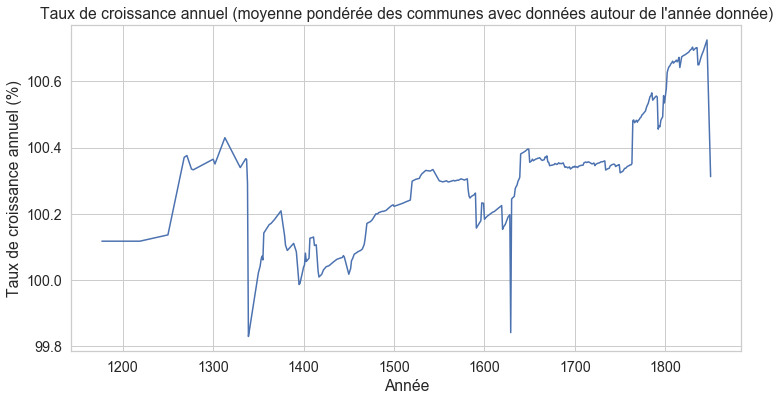

In [71]:
#avg_ygr_fig = plt.plot([yd[0] for yd in avg_ygr],[yd[2] for yd in avg_ygr])
avg_ygr_fig = sns.lineplot([yd[0] for yd in avg_ygr],[100*yd[2] for yd in avg_ygr])
#avg_ygr_fig.set_title("yearly growth rate (weighted average across communes with data in given year)")
avg_ygr_fig.set_title("Taux de croissance annuel (moyenne pondérée des communes avec données autour de l'année donnée)")
#avg_ygr_fig.set(xlabel='year', ylabel='yearly growth rate (%)')
avg_ygr_fig.set(xlabel='Année', ylabel='Taux de croissance annuel (%)')
avg_ygr_fig.get_figure().savefig("avg_ygr.png") 

In [72]:
df_ygr = pd.DataFrame(avg_ygr, columns = ["year","data_pop","ygr","gr","duration"])
df_ygr.head()

,year,data_pop,ygr,gr,duration
0,1177,74.000000,1.001176,1.027401,23
1,1200,76.027684,1.001176,1.010634,9
2,1209,76.836167,1.001176,1.011823,10
3,1219,77.744569,1.001176,1.037107,31
4,1250,1480.629431,1.001366,1.024875,18


### Writing out the results

In [73]:
dfcommunes = pd.DataFrame([c.to_dict() for c in communes])[columns_communes]

#pd.set_option('display.max_rows', None) 
dfcommunes

,name,canton,url,firstmention,hab_year,raw_hab_year,notes
0,Château-d'Œx,VD,/Articles/002593/?language=de,1080.0,"[{'year': 1416, 'pop': 589, 'unit': 'Einw', 't...","[{'year': '1416', 'pop': '120', 'unit': 'Haush...","hab+foyer data!, unclear population count (wit..."
1,Lutry,VD,/Articles/002420/?language=de,908.0,"[{'year': 1416, 'pop': 981, 'unit': 'Einw', 't...","[{'year': '1850', 'pop': '2011', 'unit': 'Einw...","hab+foyer data!, with or without Savigny,"
2,Ballaigues,VD,/Articles/002528/?language=de,1228.0,"[{'year': 1416, 'pop': 49, 'unit': 'Einw', 'ty...","[{'year': '1416', 'pop': '10', 'unit': 'Hausha...","hab+foyer data!,"
3,Belmont-sur-Yverdon,VD,/Articles/002623/?language=de,1154.0,"[{'year': 1409, 'pop': 152, 'unit': 'Einw', 't...","[{'year': '1409', 'pop': '31', 'unit': 'Hausha...","hab+foyer data!,"
4,Borex,VD,/Articles/002498/?language=de,1135.0,"[{'year': 1429, 'pop': 69, 'unit': 'Einw', 'ty...","[{'year': '1429', 'pop': '14', 'unit': 'Feuers...","hab+foyer data!,"
5,Ependes (VD),VD,/Articles/002635/?language=de,1154.0,"[{'year': 1404, 'pop': 83, 'unit': 'Einw', 'ty...","[{'year': '1404', 'pop': '17', 'unit': 'Hausha...","hab+foyer data!,"
6,Lignerolle,VD,/Articles/002538/?language=de,1160.0,"[{'year': 1416, 'pop': 294, 'unit': 'Einw', 't...","[{'year': '1416', 'pop': '60', 'unit': 'Feuers...","hab+foyer data!,"
7,Premier,VD,/Articles/002542/?language=de,1316.0,"[{'year': 1396, 'pop': 74, 'unit': 'Einw', 'ty...","[{'year': '1396', 'pop': '15', 'unit': 'Feuers...","hab+foyer data!,"
8,Pully,VD,/Articles/002412/?language=de,994.0,"[{'year': 1764, 'pop': 626.0, 'unit': 'Einw', ...","[{'year': '1764', 'pop': '626', 'unit': 'Einw'...","hab+foyer data!,"
9,Suchy,VD,/Articles/002650/?language=de,885.0,"[{'year': 1409, 'pop': 118, 'unit': 'Einw', 't...","[{'year': '1409', 'pop': '24', 'unit': 'Feuers...","hab+foyer data!,"


In [74]:
dfcommunes.to_csv("communes_units_converted.csv", sep=";")

In [75]:
with open('communes_units_converted.json', 'w') as json_file:
  json.dump([c.to_dict() for c in communes], json_file)

In [76]:
df_ygr.to_csv("../3_maps/avg_yearly_growth_rates.csv", sep=";", index=False)

In [77]:
communes[2161]

Commune({"hab_year": [{"year": 1764, "pop": 130.0, "unit": "Einw", "type": "original", "ygr": 1.0079563878849682, "next": 1850}, {"year": 1850, "pop": 257.0, "unit": "Einw", "type": "original", "ygr": 0.9975205575595009, "previous": 1764, "next": 1900}, {"year": 1900, "pop": 227.0, "unit": "Einw", "type": "original", "ygr": 1.002171142949833, "previous": 1850, "next": 1950}, {"year": 1950, "pop": 253.0, "unit": "Einw", "type": "original", "ygr": 0.9986098135316717, "previous": 1900, "next": 2000}, {"year": 2000, "pop": 236.0, "unit": "Einw", "type": "original", "previous": 1950}], "raw_hab_year": [{"original_text": " 1764 130 Einw.", "year": 1764, "pop": 130, "unit": " Einw", "index": 183, "problems": {}, "warnings": {}}, {"original_text": " 1850 257;", "year": 1850, "pop": 257, "unit": " Einw", "index": 199, "problems": {}, "warnings": {}}, {"original_text": " 1900 227;", "year": 1900, "pop": 227, "unit": " Einw", "index": 209, "problems": {}, "warnings": {}}, {"original_text": " 1950

# TEST